# Assignment 3 : Calibration

---
Please edit the cell below to include your name and student ID #

**name:**Mauricio Lomeli

**SID:**23329506

# 1. Parameterizing 3D Rotations

In order to optimize over the camera rotation during calibration, we need a way to parameterize the space of 3D rotations. There are many different ways to do this and each comes with different tradeoffs, but for our purposes we will adopt a simple approach of building a rotation by a sequence of rotations around the X, Y and Z axes (so called *Tait-Bryan angles*, see https://en.wikipedia.org/wiki/Euler_angles for more discussion)

## 1.1 Implement

Write a function **makerotation** which takes as input three angles **rx,ry,rz** and returns a rotation matrix corresponding to rotating by **rx** degrees around the x-axis, followed by a rotation of **ry** degrees around the y-axis, followed by a rotation of **rz** degrees around the z-axis. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import visutils
%matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [4,4]

In [2]:
def makerotation(rx,ry,rz):
    """
    Generate a rotation matrix    

    Parameters
    ----------
    rx,ry,rz : floats
        Amount to rotate around x, y and z axes in degrees

    Returns
    -------
    R : 2D numpy.array (dtype=float)
        Rotation matrix of shape (3,3)
    """
    st = lambda theta: np.sin(np.deg2rad(theta))
    ct = lambda theta: np.cos(np.deg2rad(theta))
    x = np.array([[1, 0, 0], [0, ct(rx), -st(rx)], [0, st(rx), ct(rx)]])
    y = np.array([[ct(ry), 0, st(ry)], [0, 1, 0], [-st(ry), 0, ct(ry)]])
    z = np.array([[ct(rz), -st(rz), 0], [st(rz), ct(rz), 0], [0, 0, 1]])

    return x @ y @ z
  

## 1.2 Test

Execute the test examples below and verify/convince yourself that the results are correct.

Find a way to achieve the same rotation as **makerotation(90,90,0)** but without using rotation around the x-axis.  That is, determine some angles so that **makerotation(0,?,?) == makerotation(90,90,0)**


In [3]:
#
# test your function on some simple examples
#
np.set_printoptions(precision=4,suppress=True)

print(makerotation(90,0,0))

print(makerotation(0,90,0))

print(makerotation(0,0,90))

print(makerotation(90,90,0))

ry = 90
rz = 90
print(makerotation(0,ry,rz))

# figure out what ry,rz values are needed in order to pass this test
assert((makerotation(90,90,0)-makerotation(0,ry,rz)<1e-9).all())

[[ 1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [-1.  0.  0.]]
[[ 0. -1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]
[[ 0.  0.  1.]
 [ 1.  0. -0.]
 [-0.  1.  0.]]
[[ 0. -0.  1.]
 [ 1.  0.  0.]
 [-0.  1.  0.]]


# 2. Reprojection Error

We will now specify a function which computes the reprojection error.  This is the function that we will later optimize when calibrating the camera extrinsic parameters. Take a look at the documentation for **scipy.optimize.leastsq**.  The optimizer expects that our function should take a vector of parameters and 
return a vector of residuals which it will square and sum up to get the total error. For this reason, we will structure our code in the following way. 

First, write a member function for the Camera class called **update_extrinsics** which takes a vector of 6 parameters (rx,ry,rz,tx,ty,tz). The function should keep the same intrinsic parameters (f,c) but update the extrinsic parameters (R,t) based on the entries in the parameter vector.  

Second, implement a function named **residuals** which computes the difference between a provided set of 2D point coordinates and the projection of 3D point coordinates by specified camera.  The residuals function takes as input the 3D points, the target 2D points, a camera with specified intrinsic parameters, and an extrinsic parameter vector. You should use **update_extrinsics** to update the extrinsic parameters, compute the projection of the 3D points with the updated camera and return a 1D vector containing the differences of all the x and y coordinates.


In [4]:
class Camera:
    """
    A simple data structure describing camera parameters 
    
    The parameters describing the camera
    cam.f : float   --- camera focal length (in units of pixels)
    cam.c : 2x1 vector  --- offset of principle point
    cam.R : 3x3 matrix --- camera rotation
    cam.t : 3x1 vector --- camera translation 
    
    """
    
    def __init__(self,f,c,R,t):
        self.f = f
        self.c = c
        self.R = R
        self.t = t

    def __str__(self):
        return f'Camera : \n f={self.f} \n c={self.c.T} \n R={self.R} \n t = {self.t.T}'
    
    def project(self, pts3):
        """
        Project the given 3D points in world coordinates into the specified camera    

        Parameters
        ----------
        pts3 : 2D numpy.array (dtype=float)
            Coordinates of N points stored in a array of shape (3,N)

        Returns
        -------
        pts2 : 2D numpy.array (dtype=float)
            Image coordinates of N points stored in an array of shape (2,N)

        """
        
        assert (pts3.shape[0] == 3)
        
        pcam = self.R.T @ (pts3 - self.t)
        p = self.f * (pcam / pcam[2, :])
        pts2 = p[0:2, :] + self.c
        
        assert (pts2.shape[1] == pts3.shape[1])
        assert (pts2.shape[0] == 2)

        return pts2
    

 
    def update_extrinsics(self, params):
        """
        Given a vector of extrinsic parameters, update the camera
        to use the provided parameters.
  
        Parameters
        ----------
        params : 1D numpy.array (dtype=float)
            Camera parameters we are optimizing over stored in a vector
            params[0:2] are the rotation angles, params[2:5] are the translation

        """ 
        self.R = makerotation(params[0], params[1], params[2])
        self.t = np.array([params[3:]]).T
        

In [5]:
def residuals(pts3,pts2,cam,params):
    """
    Compute the difference between the projection of 3D points by the camera
    with the given parameters and the observed 2D locations

    Parameters
    ----------
    pts3 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (3,N)

    pts2 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (2,N)

    params : 1D numpy.array (dtype=float)
        Camera parameters we are optimizing stored in a vector of shape (6)

    Returns
    -------
    residual : 1D numpy.array (dtype=float)
        Vector of residual 2D projection errors of size 2*N
        
    """
    
    
    cam.update_extrinsics(params)
    projected = cam.project(pts3)
    return (pts2 - projected).flatten()
    

Camera : 
 f=200 
 c=[[50 50]] 
 R=[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 
 t = [[ 0.5  0.5 -2.5]]
Camera : 
 f=200 
 c=[[50 50]] 
 R=[[ 0.9962 -0.0872  0.    ]
 [ 0.0872  0.9962  0.    ]
 [ 0.      0.      1.    ]] 
 t = [[ 0.5  0.5 -3. ]]
[[10.     21.4286 21.4286 10.     90.     90.     78.5714 78.5714]
 [10.     21.4286 78.5714 90.     90.     10.     21.4286 78.5714]]
[[13.8883 22.9162 27.274  19.6987 86.1117 80.3013 72.726  77.0838]
 [19.6987 27.274  77.0838 86.1117 80.3013 13.8883 22.9162 72.726 ]]


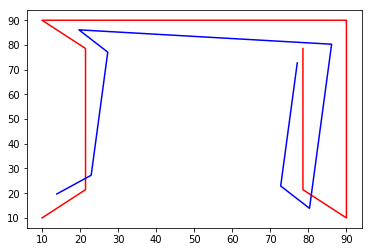


 residuals of camB relative to camA
[-3.8883 -1.4877 -5.8455 -9.6987  3.8883  9.6987  5.8455  1.4877 -9.6987
 -5.8455  1.4877  3.8883  9.6987 -3.8883 -1.4877  5.8455]
[[-3.8883 -1.4877 -5.8455 -9.6987  3.8883  9.6987  5.8455  1.4877]
 [-9.6987 -5.8455  1.4877  3.8883  9.6987 -3.8883 -1.4877  5.8455]]

 residuals of camA relative to camB
[ 3.8883  1.4877  5.8455  9.6987 -3.8883 -9.6987 -5.8455 -1.4877  9.6987
  5.8455 -1.4877 -3.8883 -9.6987  3.8883  1.4877 -5.8455]
[[ 3.8883  1.4877  5.8455  9.6987 -3.8883 -9.6987 -5.8455 -1.4877]
 [ 9.6987  5.8455 -1.4877 -3.8883 -9.6987  3.8883  1.4877 -5.8455]]


In [6]:
#
# Test the residual function to make sure it is doing the right thing.
#

# create two cameras with same intrinsic but slightly different extrinsic parameters
camA = Camera(f=200,c=np.array([[50,50]]).T,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))
camB = Camera(f=200,c=np.array([[50,50]]).T,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))

paramsA = np.array([0,0,0,0.5,0.5,-2.5])
paramsB = np.array([0,0,5,0.5,0.5,-3])
camA.update_extrinsics(paramsA)
camB.update_extrinsics(paramsB)

print(camA)
print(camB)

# create a test object (corners of a 3D cube) 
pts3 = np.array([[0,0,0],[0,0,1],[0,1,1],[0,1,0],[1,1,0],[1,0,0],[1,0,1],[1,1,1]]).T

# visualize the two projections
pts2A = camA.project(pts3)
pts2B = camB.project(pts3)
print(pts2A)
print(pts2B)

plt.plot(pts2A[0,:],pts2A[1,:],'r')
plt.plot(pts2B[0,:],pts2B[1,:],'b')
plt.show()

# double check that the residuals are the same as the difference in the reprojected coordinates
print("\n residuals of camB relative to camA")
print(residuals(pts3,pts2A,camB,paramsB))
print(pts2A-pts2B)

print("\n residuals of camA relative to camB")
print(residuals(pts3,pts2B,camA,paramsA))
print(pts2B-pts2A)


# 3. Camera Pose Estimation

We are now ready to estimate camera pose using optimize.  Implement a function **calibratePose** which takes as input the 3D coordinates of a calibration object, the observed 2D coordinates in the image, and an initial guess of the camera. Your function should use **scipy.optimize.leastsq** to optimize the extrinsic parameters in order to minimize the reprojection error. Since the **residuals** function takes additional arguments and **leastsq** expects a function which only takes the parameter vector as input, you should use Python's **lambda** function to wrap **residuals**, subistituting in the parameters that are fixed during the optimization. Once you have determined the optimum parameters, update the intrinsic parameters to the optimum and return the resulting camera.


## 3.1 Implementation

In [7]:
def calibratePose(pts3,pts2,cam,params_init):
    """
    Calibrate the provided camera by updating R,t so that pts3 projects
    as close as possible to pts2

    Parameters
    ----------
    pts3 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (3,N)

    pts2 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (2,N)

    cam : Camera
        Initial estimate of camera
        
    params_init : 1D numpy.array (dtype=float)
        Initial estimate of camera extrinsic parameters ()
        params[0:2] are the rotation angles, params[2:5] are the translation

    Returns
    -------
    cam : Camera
        Refined estimate of camera with updated R,t parameters
        
    """
    func = lambda rt : residuals(pts3, pts2, cam, rt)
    least = scipy.optimize.leastsq(func, params_init)[0]
    cam.update_extrinsics(least)
    
    return cam
 
    

# 3.2 Synthetic Test Example and Failure Cases

Use the code below to check that your calibrate function works. Add some code to also visualize the point locations in 3D and the location and orientation of the camera (i.e., using the 3D plotting functions from Assignment 2)

Once you are confident that your calibration function is behaving correctly, you should experiment with changing the initial parameters.  Find a set of initial parameters which yields a ***wrong*** solution (i.e. where the Final Camera is not similar to the True Camera).  In the text box below indicate what bad initialization you used and the resulting set of camera parameters after the optimization. Give a brief explanation of where this bad camera is located and what direction it is oriented in.   

**describe failure mode here**
***
params_init = np.array([180,0,0,0,0,-2])

params_init = np.array([0,0,0,222,222,-222]) 

params_init = np.array([90,90,90,0,0,-2]) 


Rotating one of the cameras half away can yield some arrow shaped result and only fits half of the points. It isn't a correct solution and the best fit is all off. Also translating it away makes the output small. Zooming too far in over enlarges the lines and are off the chart.


 True Camera
Camera : 
 f=50 
 c=[[50 50]] 
 R=[[ 1.      0.      0.    ]
 [ 0.      0.9848 -0.1736]
 [ 0.      0.1736  0.9848]] 
 t = [[-1 -1 -2]]

 Initial Camera
Camera : 
 f=50 
 c=[[50 50]] 
 R=[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 
 t = [[ 0  0 -2]]

 Final Camera
Camera : 
 f=50 
 c=[[50 50]] 
 R=[[ 1.      0.0084  0.0009]
 [-0.0081  0.9844 -0.176 ]
 [-0.0024  0.176   0.9844]] 
 t = [[-1.0201 -0.9822 -2.0022]]


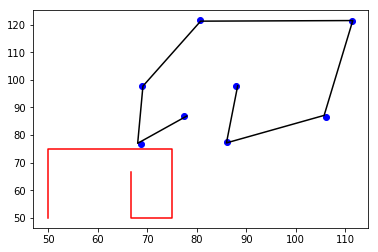

[[-1]
 [-1]
 [-2]]
[[-1.0201]
 [-0.9822]
 [-2.0022]]
[[-1.     -0.5   ]
 [-1.     -0.5944]
 [-2.     -1.4208]]
[[-1.0201 -0.5154]
 [-0.9822 -0.582 ]
 [-2.0022 -1.4232]]


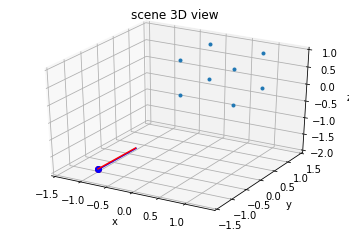

In [8]:
# 3D calibration object
pts3 = np.array([[0,0,0],[0,0,1],[0,1,1],[0,1,0],[1,1,0],[1,0,0],[1,0,1],[1,1,1]]).T

# true camera
cam_true = Camera(f=50,c=np.array([[50,50]]).T,t=np.array([[-1,-1,-2]]).T, R=makerotation(10,0,0))

print("\n True Camera")
print(cam_true)

# image of calibration object with some simulated noise in the 2D locations
pts2 = cam_true.project(pts3)
noiselevel = 0.5
noise = noiselevel * np.random.randn(pts2.shape[0], pts2.shape[1])
pts2 = pts2 + noise

# initial guess of camera params
cam = Camera(f=50,c=np.array([[50,50]]).T,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))
params_init = np.array([0,0,0,0,0,-2]) 
cam.update_extrinsics(params_init)

print("\n Initial Camera")
print(cam)
pts2init = cam.project(pts3)

# now run calibration
cam = calibratePose(pts3,pts2,cam,params_init)

print("\n Final Camera")
print(cam)
pts2final = cam.project(pts3)

#
# Plot the true, initial and final reprojections
# The final reprojection should be on top of the true image
#
plt.plot(pts2[0,:],pts2[1,:],'bo')
plt.plot(pts2init[0,:],pts2init[1,:],'r')
plt.plot(pts2final[0,:],pts2final[1,:],'k')
plt.show()

#
# Add some additional visualiztion here to show the points in 3D and the locations and orientations
# of cam_true and cam.  You can either use a 3D plot or show multiple 2D plots (e.g. overhead
# and side views)
#
##################################################################################################
##################################################################################################

fig = plt.figure()
t_cam_true = cam_true.t
t_cam = cam.t

print(t_cam_true)
print(t_cam)

# generate coordinates of a line segment running from the center
# of the camera to 2 units in front of the camera
lookL = np.hstack((t_cam_true,t_cam_true+cam_true.R @ np.array([[0.5,0.5,0.5]]).T))
lookR = np.hstack((t_cam,t_cam+cam.R @ np.array([[0.5,0.5,0.5]]).T))


print(lookL)
print(lookR)
#visualize 3D layout of points, camera positions
# and the direction the camera is pointing
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
ax.plot(t_cam_true[0],t_cam_true[1],t_cam_true[2],'ro')
ax.plot(t_cam[0],t_cam[1],t_cam[2],'bo')
ax.plot(lookL[0,:],lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[1,:],lookR[2,:],'r')
visutils.set_axes_equal_3d(ax)
visutils.label_axes(ax)
plt.title('scene 3D view')

plt.show()

In [9]:
def triangulate(pts2L, camL, pts2R, camR):
    '''
    Triangulate the set of points seen at location pts2L / pts2R in the 
    corresponding pair of cameras. Return the 3D coords relative to the
    Global coord system.
    '''
    npts = pts2L.shape[1]
    
    qL = (pts2L - camL.c) / camL.f
    qL = np.vstack((qL, np.ones((1, npts))))
    
    qR = (pts2R - camR.c) / camR.f
    qR = np.vstack((qR, np.ones((1, npts))))
    
    R = camL.R.T @ camR.R
    t = camL.R.T @ (camR.t - camL.t)
    xL = np.ones(qL.shape, dtype=float)
    xR = np.ones(qR.shape, dtype=float)
    for i in range(npts):
        A = np.vstack((qL[:, i], -R @ qR[:, i])).T
        z, _, _, _ = np.linalg.lstsq(A, t, rcond=None)
        xL[:, i] = z[0] * qL[:, i]
        xR[:, i] = z[1] * qR[:, i]
    pts3L = camL.R @ xL + camL.t
    pts3R = camR.R @ xR + camR.t
    pts3 = .5 * (pts3L + pts3R)
    return pts3

# 4. Calibration from real images

There is a provided set of calibration images (images of a planar checkerboard) along with stereo pair depicting an object. In order to calibrate the intrinsic camera parameters we will use the OpenCV library which includes functionality for automatically detecting corners of the checkerboard and estimating intrinsic parameters. To install OpenCV python libraries in your Anaconda environment. You can do this from the terminal via the command **conda install opencv** or via the Anconda Navigator gui.

I have provide a standalone script **calibrate.py** which uses OpenCV to carry out calibration of the camera intrinsic parameters for a series of checkerboard images. Read through the provided script to understand the code and modify file paths as necessary in order to compute the intrinsic camera parameters from the set of provided calibration images.


## 4.1 Implementation

Fill in the code snippet below to carry out the following steps.

1. Load in the intrinsic parameter calibration data saved by the script in *calibration.pickle*. Since our camera model assumes that the focal length is the same in the x and y axes, you can set your f to be the average of the two estimated by the script.

2. Load in the test images *Left.jpg* and *Right.jpg* and use the **cv2.findChessboardCorners** function in order to automatically get the 2D coordinates of the corners in the image.

3. Specify the true 3D coordinates of the 6x8 grid of checkerboard corners. The squares are 2.8cm x 2.8cm.

5. Use your **calibratePose** function to estimate the R,t for each camera. You will likely need to experiment with selecting the initial parameters in order to get a good solution (e.g., translate so the cameras have positive z coordinates and rotate so they are looking down on the checkerboard).


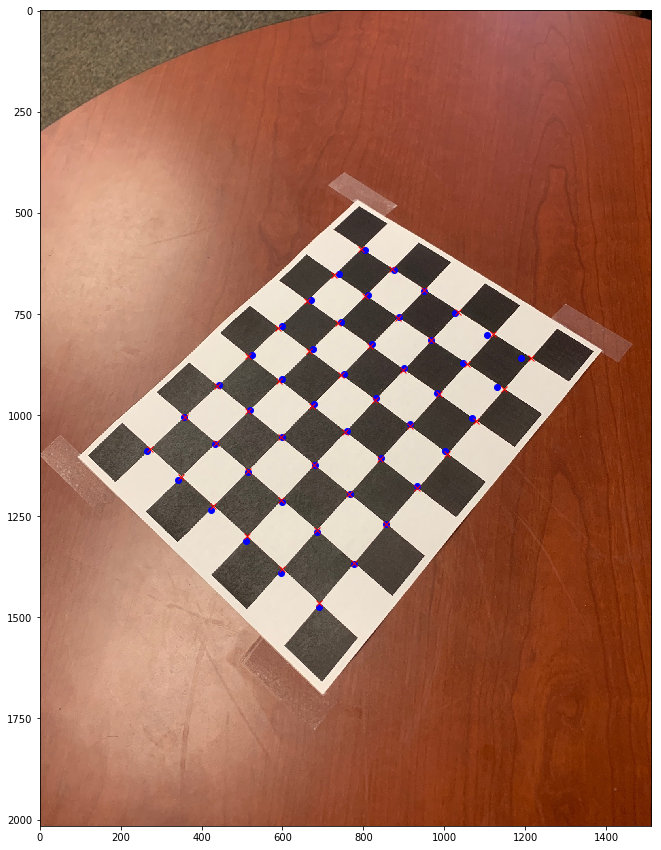

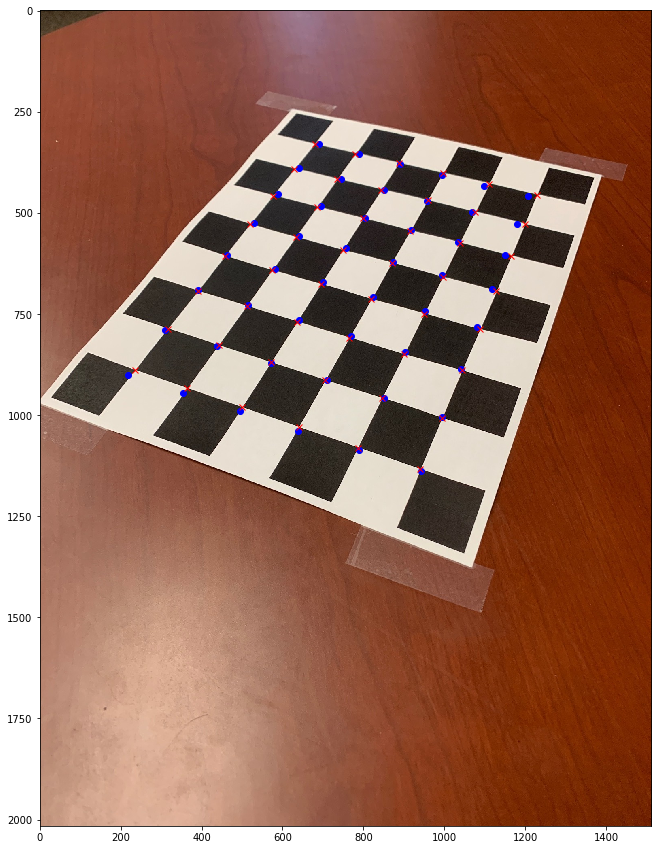

{'fx': 1559.1187537573355, 'fy': 1562.9091851129842, 'cx': 1021.146539341846, 'cy': 755.8365178567909, 'dist': array([[ 0.274 , -1.4965,  0.0008, -0.0008,  2.1928]])}


In [10]:
import cv2

# load in the intrinsic camera parameters from 'calibration.pickle'
import pickle
file = open('calibration.pickle', 'rb')
obj = pickle.load(file)

# create Camera objects representing the left and right cameras
# use the known intrinsic parameters you loaded in.
f = (obj['fx'] + obj['fy'])/2
c = np.array([[obj['cx'], obj['cy']]]).T
t = np.array([0, 0, -2]).T
R = makerotation(0,0,0)
camL = Camera(f, c, R, t)
camR = Camera(f, c, R, t)

# load in the left and right images and find the coordinates of
# the chessboard corners using OpenCV
imgL = plt.imread('calib1/Left.jpg')
ret, cornersL = cv2.findChessboardCorners(imgL, (8,6), None)
pts2L = cornersL.squeeze().T

imgR = plt.imread('calib1/Right.jpg')
ret, cornersR = cv2.findChessboardCorners(imgR, (8,6), None)
pts2R = cornersR.squeeze().T

# generate the known 3D point coordinates of points on the checkerboard in cm
pts3 = np.zeros((3,6*8))
yy,xx = np.meshgrid(np.arange(8),np.arange(6))
pts3[0,:] = 2.8*xx.reshape(1,-1)
pts3[1,:] = 2.8*yy.reshape(1,-1)

# Now use your calibratePose function to get the extrinsic parameters
# for the two images. You may need to experiment with the initialization
# in order to get a good result

rt = np.array([0, 0, 0, 0, 0, -2])
camL = calibratePose(pts3, pts2L, camL, rt)
camR = calibratePose(pts3, pts2R, camR, rt)

# As a final test, triangulate the corners of the checkerboard to get back there 3D locations
pts3r = triangulate(pts2L, camL, pts2R, camR)

# Display the reprojected points overlayed on the images to make 
# sure they line up
plt.rcParams['figure.figsize']=[15,15]
pts2Lp = camL.project(pts3)
plt.imshow(imgL)
plt.plot(pts2Lp[0,:],pts2Lp[1,:],'bo')
plt.plot(pts2L[0,:],pts2L[1,:],'rx')
plt.show()

pts2Rp = camR.project(pts3)
plt.imshow(imgR)
plt.plot(pts2Rp[0,:],pts2Rp[1,:],'bo')
plt.plot(pts2R[0,:],pts2R[1,:],'rx')
plt.show()

print(obj)



The code below provides a visualization of the estimate camera positions relative to the checkerboard.

Text(0, 0.5, 'y')

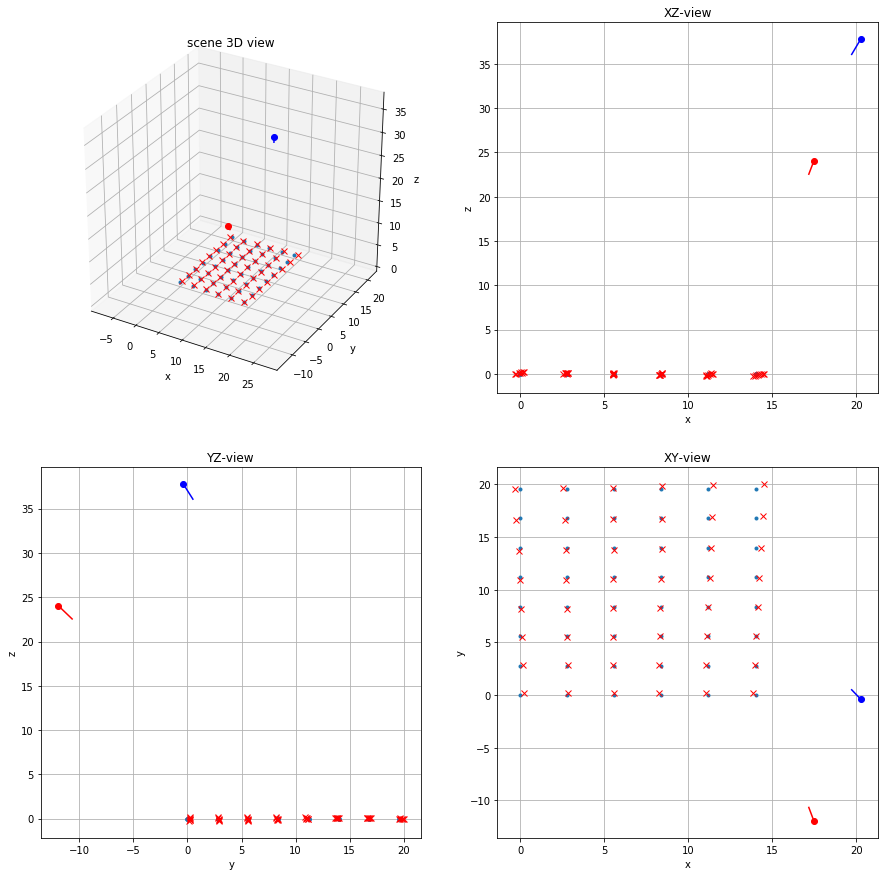

In [11]:
# generate coordinates of a line segment running from the center
# of the camera to 3 units in front of the camera
lookL = np.hstack((camL.t,camL.t+camL.R @ np.array([[0,0,2]]).T))
lookR = np.hstack((camR.t,camR.t+camR.R @ np.array([[0,0,2]]).T))

# visualize the left and right image overlaid
fig = plt.figure()
ax = fig.add_subplot(2,2,1,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
ax.plot(pts3r[0,:],pts3r[1,:],pts3r[2,:],'rx')
ax.plot(camR.t[0],camR.t[1],camR.t[2],'ro')
ax.plot(camL.t[0],camL.t[1],camL.t[2],'bo')
ax.plot(lookL[0,:],lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[1,:],lookR[2,:],'r')
visutils.set_axes_equal_3d(ax)
visutils.label_axes(ax)
plt.title('scene 3D view')

ax = fig.add_subplot(2,2,2)
ax.plot(pts3[0,:],pts3[2,:],'.')
ax.plot(pts3r[0,:],pts3r[2,:],'rx')
ax.plot(camR.t[0],camR.t[2],'ro')
ax.plot(camL.t[0],camL.t[2],'bo')
ax.plot(lookL[0,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[2,:],'r')
plt.title('XZ-view')
plt.grid()
plt.xlabel('x')
plt.ylabel('z')

ax = fig.add_subplot(2,2,3)
ax.plot(pts3[1,:],pts3[2,:],'.')
ax.plot(pts3r[1,:],pts3r[2,:],'rx')
ax.plot(camR.t[1],camR.t[2],'ro')
ax.plot(camL.t[1],camL.t[2],'bo')
ax.plot(lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[1,:],lookR[2,:],'r')
plt.title('YZ-view')
plt.grid()
plt.xlabel('y')
plt.ylabel('z')

ax = fig.add_subplot(2,2,4)
ax.plot(pts3[0,:],pts3[1,:],'.')
ax.plot(pts3r[0,:],pts3r[1,:],'rx')
ax.plot(camR.t[0],camR.t[1],'ro')
ax.plot(camL.t[0],camL.t[1],'bo')
ax.plot(lookL[0,:],lookL[1,:],'b')
ax.plot(lookR[0,:],lookR[1,:],'r')
plt.title('XY-view')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

***
## 4.2 Recovered Pose
Using the provided calibration images, what are the recovered parameters for the left and right cameras?  How far apart are the camera centers in centimeters (i.e. what is the baseline) ?

In [12]:
print(camL.t)
print(camR.t)
print(np.linalg.norm(camL.t - camR.t))

[[20.2537]
 [-0.385 ]
 [37.7857]]
[[ 17.4717]
 [-11.9475]
 [ 24.0514]]
18.167595094747806


\begin{equation*}
\mathbf{camL} = (20.2537, -0.385, 37.7857)
\end{equation*}

\begin{equation*}
\mathbf{camR} = (17.4717, -11.9475, 24.0514)
\end{equation*}


\begin{equation*}
d(\vec{\mathbf{camL}}, \vec{\mathbf{camR}}) = \sqrt{(17.4717 - 20.2537)^2 + ((-11.9475) - (-0.385))^2 + (24.0514 - 37.7857)^2} = 18.167595094747806 cm = \mathbf{baseline}
\end{equation*}


***
## 4.3 Reconstruction Accuracy

Using the estimated camL and camR and the 2D point locations, triangulate to get 3D locations. What is the average error (in cm) for your recovered 3D locations of the grid corner points relative to their true coordinates?  Where might this error be coming from?

In [13]:
difference = (pts3r-pts3)
distance = np.sqrt(np.sum(difference ** 2, axis=0))
average = np.average(distance)
print("distance = " + str(distance))
print("Average = " + str(average))
print("Norm = " + str(np.linalg.norm(difference)))

distance = [0.387  0.2382 0.2158 0.3071 0.3415 0.3562 0.3162 0.3238 0.2598 0.0801
 0.0975 0.2063 0.2768 0.2892 0.242  0.2585 0.226  0.1138 0.1134 0.158
 0.2109 0.2373 0.1427 0.1177 0.2784 0.2232 0.1847 0.1703 0.1502 0.1556
 0.1153 0.2092 0.3176 0.2315 0.2242 0.1144 0.1269 0.1889 0.2216 0.3936
 0.3369 0.2777 0.1266 0.1649 0.2346 0.3293 0.449  0.6613]
Average = 0.237541082184226
Norm = 1.8023392947785226


\begin{equation*}
\mathbf{Average Error (cm)} = average(\sqrt{(pts3 - pts3r)^2} = 0.237541082184226
\end{equation*}
***
The error might be comming from handling precision of floating point numbers and with least sq function. In this case its more likely it is the least sq function. The least sq function makes the best approximation for best fit.

"The least squares method does not give the most probable true value."

https://www.researchgate.net/profile/Christian_Bauckhage/publication/273133972_NumPy_SciPy_Recipes_for_Data_Science_Ordinary_Least_Squares_Optimization/links/54fea80f0cf2741b69f0ef93.pdf

https://math.stackexchange.com/questions/63238/why-do-we-use-a-least-squares-fit

https://www.investopedia.com/terms/l/least-squares-method.asp


***
## 4.4 Focal Length

The checkerboard photos were taken with an iPhone Xs. Teardowns of this device reveal that the sensor is 5.6mm wide. Based on this and your recovered value for f, what was the focal length in millimeters? Explain how you computed this. Is the result you get a reasonable match to the published focal length of of 4.25mm?

\begin{equation*}
\mathbf{Focal Length (mm)} = \frac {1561.01396994351599 * 5.6mm}{1512} = 5.78
\end{equation*}
***
imgL gets us the horizontal pixel size of 1512, 
f is from the pickle file, 
5.6mm is the given sensor width. 

I believe there is a little more going on with the camera and its sensor. Maybe we aren't using it to its maximum potential. "Each sensor measures 7.01 x 5.79 mm, with an active area that's 5.6 x 4.2 mm". The available depth of field increases as the sensor size and lens focal length decrease. So the iPhone Xs boasts a greater available depth of field than a 5.6mm lens, but because "Apple also has a new Depth Control feature that allows you to adjust the depth of field" then it was probably the user who didn't use the greater depth of field by changing the arpeture. To answer the question, no. The 5.78mm value I recovered didn't match the 4.25mm published focal length. As for being reasonable, it depends on the user and manufacturer's choice to explain how to obtain the 4.25mm results.

https://improvephotography.com/55460/what-is-the-focal-length-of-an-iphone-camera-and-why-should-i-care/

https://en.wikipedia.org/wiki/Image_sensor_format

https://www.dpreview.com/news/1564509739/iphone-xs-max-teardown-reveals-new-sensor-with-more-focus-pixels